# UChicago Trading Competition 2025 - Case 2
#### Written by Ephram Cukier
---

This past weekend, I competed in the 13th annual UChicago Trading competition, a very rigorous competition with 40 teams composed of students mainly from UChicago, Stanford, MIT, and the Ivies. My team (CU Boulder) earned second overall, with third place in Case 1 and fourth place in Case 2. This is an explanation of how I arrived at the Case 2 solution. You can read about my Case 1 solution [here](../case-1/).

You can also download <a href="case2.ipynb" download>this notebook</a> and <a href="Case2.csv" download>the data</a> to play around with this yourself.

## Step 0 - Understanding the Problem
This case was about rebalancing a portfolio to maximize the sharpe ratio across six assets. The Sharpe ratio measures portfolio returns versus volatility (here we assume a risk‑free rate of zero). Essentially, we want to maximize the returns we get per unit of risk we take on. We were given 5 years of historical data, and needed to construct a model that would have the best sharpe ratio during the following 6 months (which we were obviously not given in advance). 

The first thing I wanted to understand was just what this data looked like, 

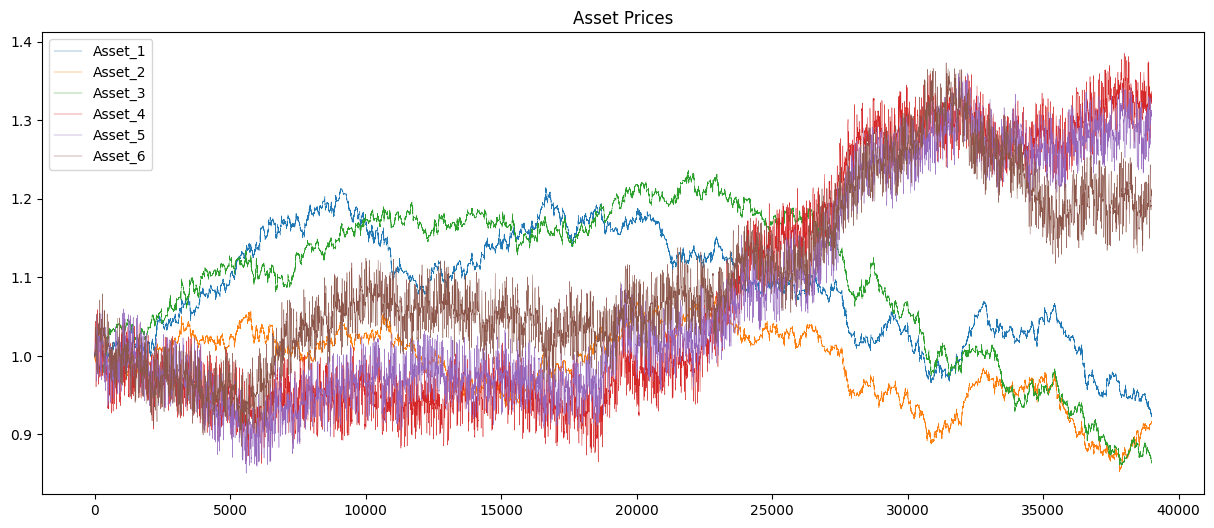

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("Case2.csv")
fig = plt.figure()
fig.set_size_inches(15, 6)

for i in range(1, 7):
    column = f"Asset_{i}"
    plt.plot(data[column], label=column, linewidth = 0.3)  
plt.legend()
plt.title("Asset Prices")
plt.show()

## Step 1 - The Basic Strategy
The first thing I noticed was that there was a lot of noise in each of the assets. But looking at it more, the noise seemed incredibly repetitive, at least visually. If it really was as repetitive as it looked, then a momentum based strategy could perform quite well. To test this, I implemented a basic crossover trading algorithm. Crossover trading has a long moving average and a short moving average. When the short average "crosses over" the long average, it's a buy/sell signal depending on the direction of the movement. You can read more about it on [Investopedia](https://www.investopedia.com/terms/c/crossover.asp).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
data = pd.read_csv('Case2.csv')


TRAIN, TEST = train_test_split(data, test_size = 0.8, shuffle = False)



from tqdm import tqdm
def grading(train_data, test_data): #Their provided grader script (I added tqdm because some strategies can be quite slow) 
    weights = np.full(shape=(len(test_data.index),6), fill_value=0.0)
    alloc = Allocator(train_data)
    for i in tqdm(range(0,len(test_data))):
        weights[i,:] = alloc.allocate_portfolio(test_data.iloc[i,:])
        if np.sum(weights < -1) or np.sum(weights > 1):
            raise Exception("Weights Outside of Bounds")
    
    capital = [1]
    for i in tqdm(range(len(test_data) - 1)):
        shares = capital[-1] * weights[i] / np.array(test_data.iloc[i,:])
        balance = capital[-1] - np.dot(shares, np.array(test_data.iloc[i,:]))
        net_change = np.dot(shares, np.array(test_data.iloc[i+1,:]))
        capital.append(balance + net_change)
    capital = np.array(capital)
    returns = (capital[1:] - capital[:-1]) / capital[:-1]
    
    if np.std(returns) != 0:
        sharpe = np.mean(returns) / np.std(returns)
    else:
        sharpe = 0
        
    return sharpe, capital, weights

def do_grading_stuff(is_log = True):
    sharpe, capital, weights = grading(TRAIN, TEST)
    #Sharpe gets printed to command line
    print('Per tick sharpe:', sharpe)
    print('Annualized Sharpe:', sharpe * math.sqrt(260*30)) #30 ticks per day, 260 trading days per year

    plt.figure(figsize=(10, 6), dpi=80)
    plt.title("Capital")
    if is_log:
        plt.yscale('log')
    plt.plot(np.arange(len(TEST)), capital)
    plt.show()


100%|██████████| 31199/31199 [00:01<00:00, 18034.70it/s]


Per tick sharpe: 0.6838577163894852
Annualized Sharpe: 60.39667817744983


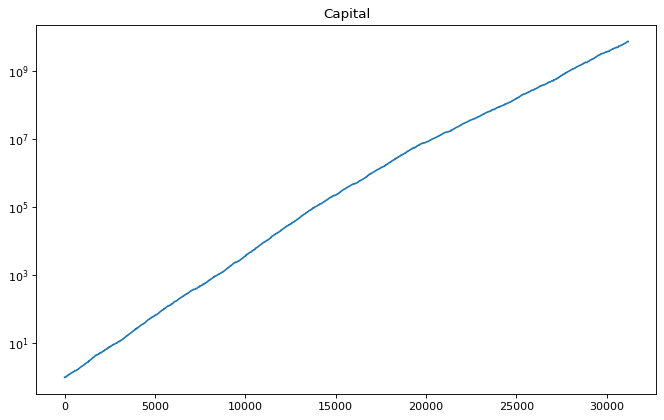

In [3]:
class Allocator():
    def __init__(self, train_data):
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()

    def normalize(self, vector):
        vector = np.array(vector)
        total = np.sum(np.abs(vector))
        return vector / total if total != 0 else vector


    
    def allocate_portfolio(self, asset_prices):
        new_row = pd.Series(asset_prices, index=self.train_data.columns)
        new_row_df = pd.DataFrame([new_row])
        
        self.running_price_paths = pd.concat([self.running_price_paths, new_row_df], ignore_index=True)
        
        short_window = 2
        long_window = 4
        
        weights = np.zeros(len(asset_prices))

        for i, asset in enumerate(self.train_data.columns):
            price_series = self.running_price_paths[asset]
            
            if len(price_series) >= long_window:
                short_ma = price_series.rolling(window=short_window).mean().iloc[-1]
                long_ma = price_series.rolling(window=long_window).mean().iloc[-1]
                
                if short_ma > long_ma:
                    weights[i] = 1.0
                elif short_ma < long_ma:
                    weights[i] = -1.0

                else:
                    weights[i] = 0.0
            else:
                weights[i] = 0.0

        weights = self.normalize(weights)

        return weights
do_grading_stuff()

This was FAR better than I could have predicted the first run to go. Make note of the **logarithmic** scale of y-axis on that graph. 1e9. If this was a real-world trading strategy, and you invested $\$1$ at the beginning, you would have $\$7,000,000,000$ (seven billion with a 'b') after 4 years. This quickly taught me that whatever they were doing to generate the data was not very realistic. Their generation patterns were algorithmic and exploitable. 

To further drive this point home, some very basic optimizations on top of this (running a sweep on the training data to determine a good window size and scaling weights based on volatility) just made the results even more unfathomable. 

[0.00024611 0.0003275  0.00025254 0.01287168 0.01292082 0.01104698]


100%|██████████| 31199/31199 [00:01<00:00, 18109.92it/s]


Per tick sharpe: 0.9831857525928858
Annualized Sharpe: 86.8326145408094


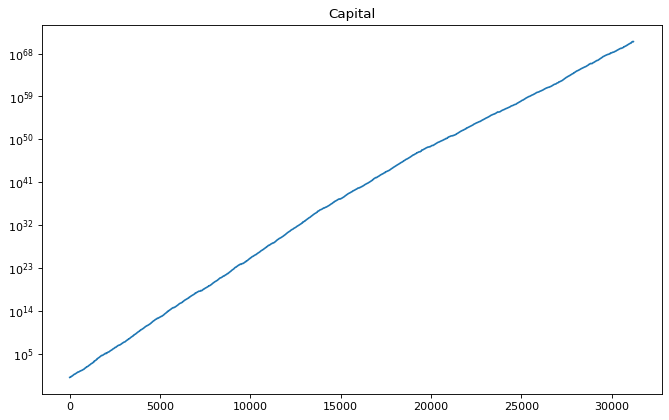

In [4]:
class Allocator():
    def __init__(self, train_data, short_windows=[17, 7, 9, 1, 1, 1], long_windows=[24, 28, 30, 3, 3, 3]):
        #stds of each asset
        self.asset_coefs = (np.array([.001252518665, 0.001345246712, 0.00126061534, 0.003368285059, 0.003371494789, 0.003241983945]) * 100) **4 

        print(self.asset_coefs)
        self.running_price_paths = train_data.copy()
        self.train_data = train_data.copy()
        self.short_windows = short_windows
        self.long_windows = long_windows
        for i in tqdm(range(0,len(train_data))):
            self.allocate_portfolio(train_data.iloc[i,:])

    def normalize(self, vector):
        vector = np.array(vector)
        total = max(abs(vector))
        return vector / total if total != 0 else vector


    
    def allocate_portfolio(self, asset_prices):
        new_row = pd.Series(asset_prices, index=self.train_data.columns)
        new_row_df = pd.DataFrame([new_row])
        
        self.running_price_paths = pd.concat([self.running_price_paths, new_row_df], ignore_index=True)
        
        
        
        weights = np.zeros(len(asset_prices))

        for i, asset in enumerate(self.train_data.columns):
            price_series = self.running_price_paths[asset]
            
            if len(price_series) >= self.long_windows[i]:
                short_ma = price_series.rolling(window=self.short_windows[i]).mean().iloc[-1]
                long_ma = price_series.rolling(window=self.long_windows[i]).mean().iloc[-1]
                
                if short_ma > long_ma:
                    weights[i] = 1
                elif short_ma < long_ma:
                    weights[i] = -1

                else:
                    weights[i] = 0.0
            else:
                weights[i] = 1

        weights = self.normalize(weights * self.asset_coefs)

        return weights
do_grading_stuff()

The y-axis scale here is 1e68. And we're only getting started.

## Step 2 - Reconstructing the Generator Function

Given how well such a simple solution was performing, I figured the organizer's generation function couldn't have been too complex. After testing out a bunch of "stock generation algorithms", one seemed to hold promise: Geometric Brownian Motion (GBM). GBM assumes there is some expected annual return ($\mu$) and some volatility ($\sigma$). At each timestamp, the asset moves according to these two values and a value randomly chosen from a normal distribution. Because I have years of historical data, I can calculate $\mu$ and $\sigma$, then plot the z-scores necessary to generate each move, and I should get a normal distribution. 

Estimated sigma (annual): 0.110617
Estimated mu (annual):    -0.009651
Mean of Z: -0.000000, Std of Z: 1.000000


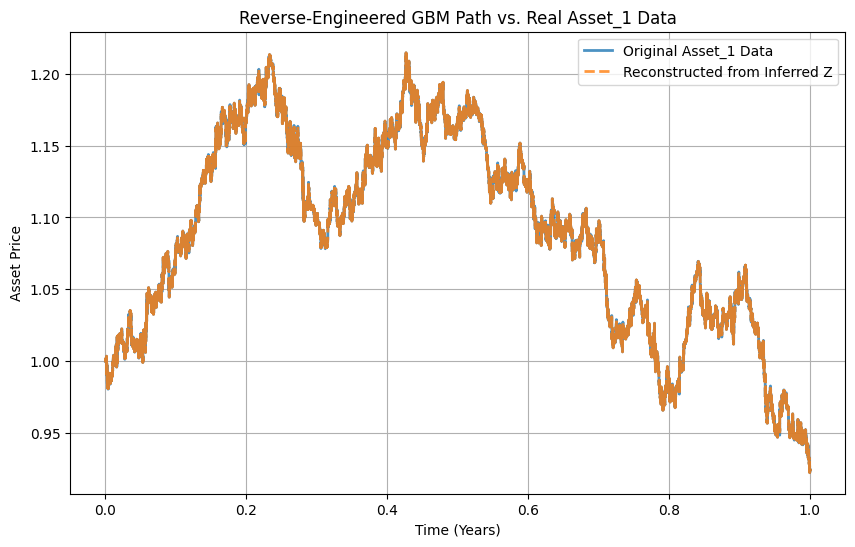

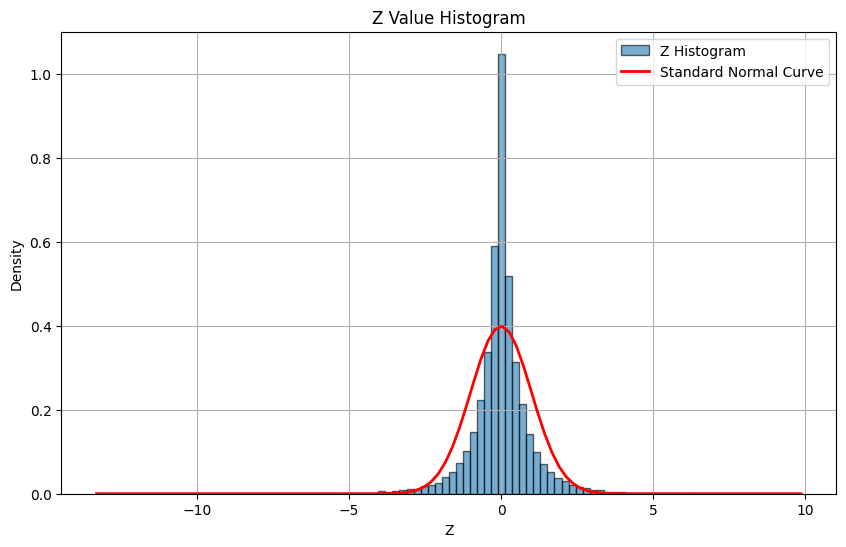

Estimated sigma (annual): 0.286290
Estimated mu (annual):    0.079633
Mean of Z: 0.000000, Std of Z: 1.000000


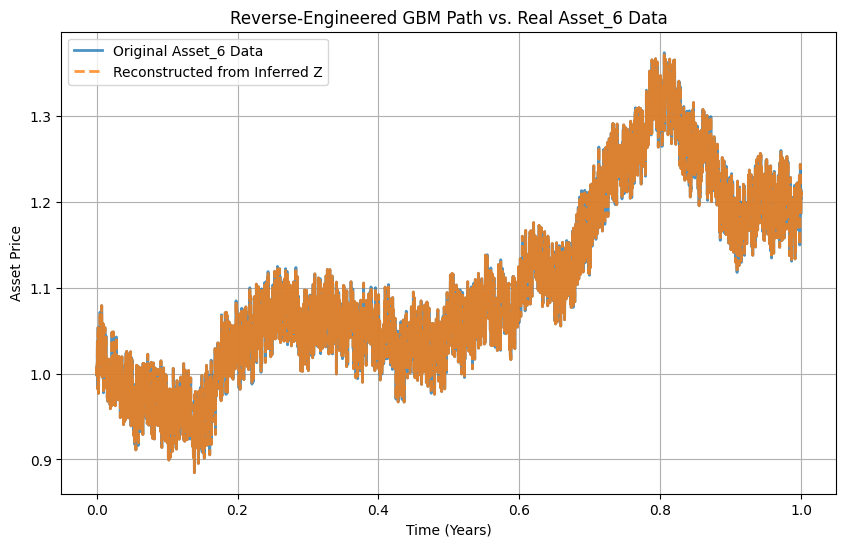

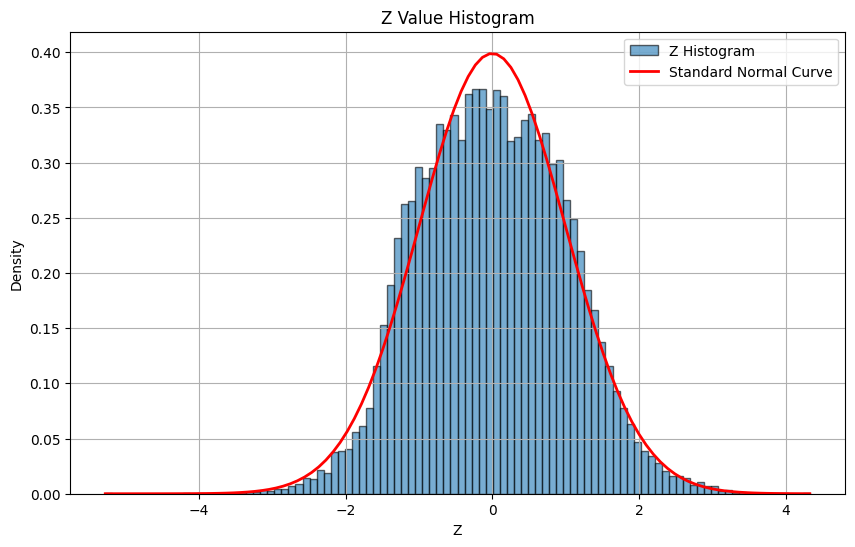

In [5]:
import scipy.stats as stats
def reconstruct_gbm(asset_name):
    df = pd.read_csv('Case2.csv')
    asset_real = df[asset_name].values

    N = len(asset_real) - 1
    Delta_t = 1.0 / 7800

    log_returns = np.log(asset_real[1:] / asset_real[:-1]) 

    r_mean = log_returns.mean()   
    r_var = log_returns.var(ddof=1) 

    sigma = np.sqrt(r_var / Delta_t)
    mu = (r_mean / Delta_t) + 0.5 * sigma**2

    print(f"Estimated sigma (annual): {sigma:.6f}")
    print(f"Estimated mu (annual):    {mu:.6f}")

    Z = (log_returns - ((mu - 0.5*sigma**2) * Delta_t)) / (sigma * np.sqrt(Delta_t))

    np.savetxt('zs.txt', Z)
    
    print(f"Mean of Z: {Z.mean():.6f}, Std of Z: {Z.std(ddof=1):.6f}")

    S_reconstructed = np.zeros_like(asset_real)
    S_reconstructed[0] = asset_real[0] 


    for t in range(N):
        S_reconstructed[t+1] = S_reconstructed[t] * np.exp(
            (mu - 0.5*sigma**2)*Delta_t + sigma*np.sqrt(Delta_t)*Z[t]
        )
        z = np.random.normal()
    

    time = np.linspace(0, 1.0, N + 1) 

    plt.figure(figsize=(10, 6))
    plt.plot(time, asset_real, label=f'Original {asset_name} Data', lw=2, alpha=0.8)
    plt.plot(time, S_reconstructed, label='Reconstructed from Inferred Z', lw=2, alpha=0.8, linestyle='--')
    plt.title(f"Reverse-Engineered GBM Path vs. Real {asset_name} Data")
    plt.xlabel("Time (Years)")
    plt.ylabel("Asset Price")
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure(figsize=(10, 6))

    count, bins, ignored = plt.hist(Z, bins=100, density=True, alpha=0.6, edgecolor='black', label='Z Histogram')

    x = np.linspace(np.min(Z), np.max(Z), 100)

    plt.plot(x, stats.norm.pdf(x, 0, 1), 'r-', lw=2, label='Standard Normal Curve')
    plt.title("Z Value Histogram")
    plt.xlabel("Z")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
reconstruct_gbm("Asset_1")
reconstruct_gbm("Asset_6")

This was an incredibly exciting result, but raised an important question. Why was my previous strategy working? If the Z scores were actually chosen randomly, each move would be independent from the prior, and so a momentum strategy wouldn't work. The distribution not being *entirely* normal further points to the organizers doing something strange with the generator function. I would have loved to investigate this further However, I only started "Step 2" of this writeup two hours prior to the deadline, and there was roughly half an hour remaining. Needing to find something "good enough" very quickly, I decided to create a neural network to see if it could very quickly find a pattern amongst the data.  

starting fit
MLP MSE: 0.027407289793655115


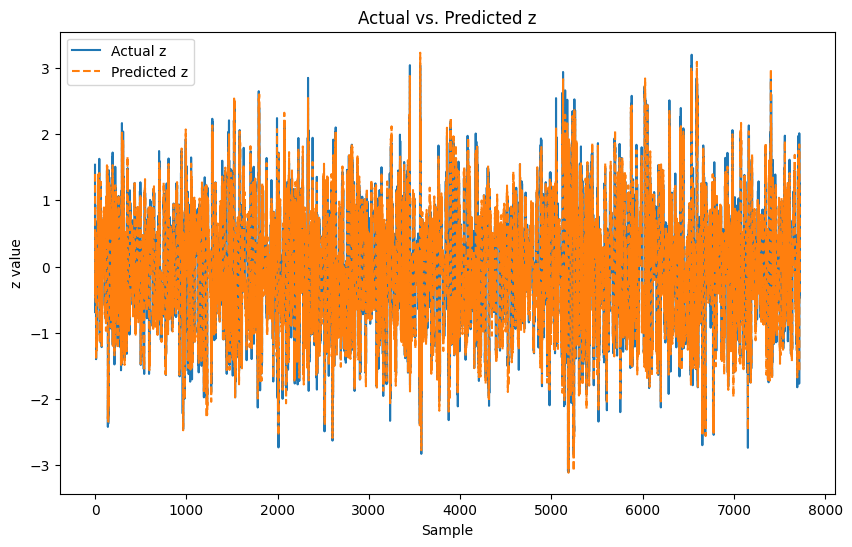

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

zs = np.loadtxt("zs.txt")

num_lags = 400


X = []
y = []
for i in range(num_lags, len(zs)):
    X.append(zs[i - num_lags:i])
    y.append(zs[i])
X = np.array(X)
y = np.array(y)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("starting fit")
mlp = MLPRegressor(hidden_layer_sizes=(100, ), activation='relu', solver='adam', max_iter=500)
mlp.fit(X, y)
model=mlp

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MLP MSE:", mse)

plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual z")
plt.plot(y_pred, label="Predicted z", linestyle="--")
plt.title("Actual vs. Predicted z")
plt.xlabel("Sample")
plt.ylabel("z value")
plt.legend()
plt.show()


These look like they're *probably* similar, but let's zoom in on a random spot to get a better look

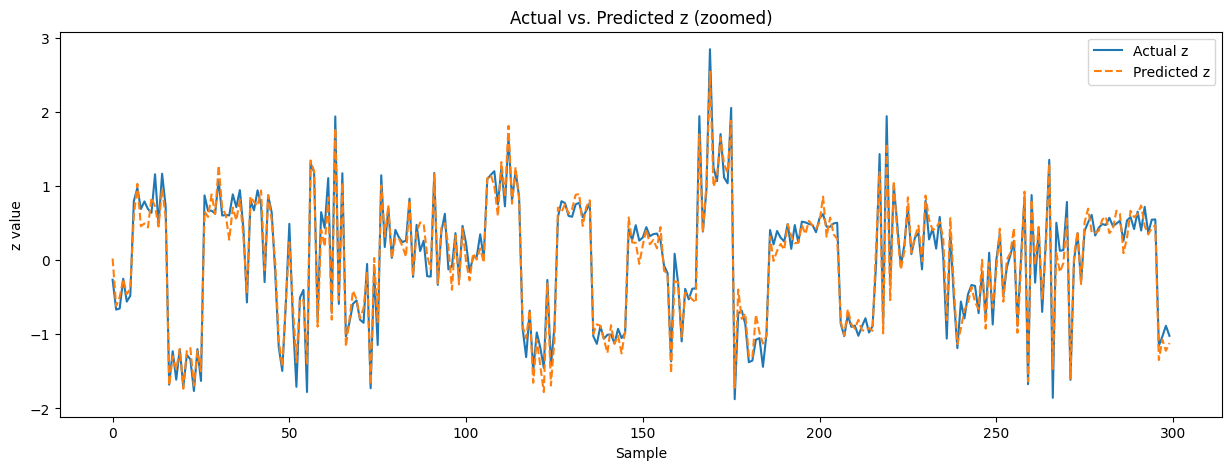

In [7]:
import random
window_size = 300
start = random.randint(0,len(y_test)-window_size)
end = start+window_size
plt.figure(figsize=(15, 5))
plt.plot(y_test[start:end], label="Actual z")
plt.plot(y_pred[start:end], label="Predicted z", linestyle="--")
plt.title("Actual vs. Predicted z (zoomed)")
plt.xlabel("Sample")
plt.ylabel("z value")
plt.legend()
plt.show()

I wasn't entirely sure how the model was finding the correlation that it was, but that's the trade-off you make when deploying trained models (at least on the miniature scale). You exchange inspectability for ease of creation. But there were 18 minutes remaining, so I would only have time to run a few tests simultaneously before I had to submit. Of the three trials I ran, this one performed the best (that finished within the 10 minute time limit). 


100%|██████████| 31199/31199 [00:01<00:00, 18288.54it/s]


Per tick sharpe: 1.4011366994002326
Annualized Sharpe: 123.74504270138738


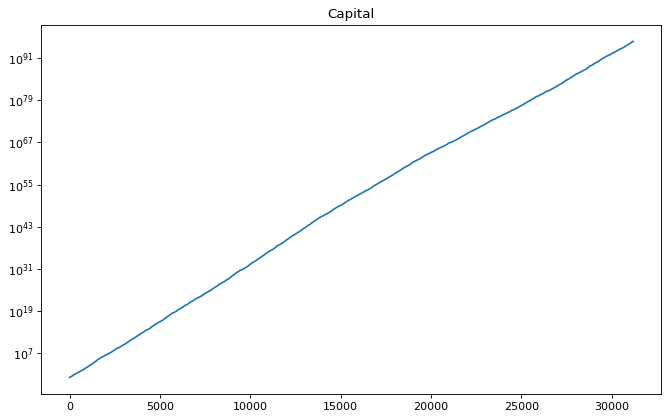

In [10]:
NUM_LAGS = 30
UPDATE_EVERY = 5_000
EPS = 0.01
HIDDEN_SIZE = 50
class Allocator():
    def recreate_gbm(self, train_data: pd.DataFrame):
        self.reconstructed = [(0,0,0,0) for _ in range(train_data.shape[1])] # (z_thresh, Z, model, mu, sigma)
        for asset_id, asset_name in enumerate(tqdm(train_data.columns, desc='Fitting Model')):
           
            asset_data = np.array(train_data[asset_name])
            
            Delta_t = 1.0 / 7800
            
            log_returns = np.log(asset_data[1:] / asset_data[:-1])
            r_mean = log_returns.mean()   
            r_var = log_returns.var(ddof=1)
            
            sigma = np.sqrt(r_var / Delta_t)
            mu = (r_mean / Delta_t) + 0.5 * sigma**2

            Z = (log_returns - ((mu - 0.5*sigma**2)*Delta_t)) / (sigma*np.sqrt(Delta_t))
            
            z_thresh = -(mu - (sigma**2)/2)/sigma

            X = []
            y = []
            for i in range(NUM_LAGS, len(Z)):
                X.append(Z[i - NUM_LAGS:i])
                y.append(Z[i])
            X = np.array(X)
            y = np.array(y)

          


            mlp = MLPRegressor(hidden_layer_sizes=(HIDDEN_SIZE, ), activation='relu', solver='adam', max_iter=500)
            mlp.fit(X, y)
            model = mlp

            self.reconstructed[asset_id] = (z_thresh, Z, model, mu, sigma)

    def __init__(self, train_data: pd.DataFrame):
        self.train_data = train_data.copy()
        self.running_price_paths = train_data.copy()
        self.tick = 0
        self.recreate_gbm(self.running_price_paths)
        
    def allocate_portfolio(self, asset_prices: np.ndarray):
        self.tick += 1
        if self.tick %UPDATE_EVERY == 0:
            self.recreate_gbm(self.running_price_paths)
        new_row = pd.DataFrame([asset_prices], columns=self.running_price_paths.columns)
        self.running_price_paths = pd.concat([self.running_price_paths, new_row], ignore_index=True)
        
        Delta_t = 1.0 / 7800  
        

        weights = [0,0,0,0,0,0]
        for asset_id, asset_name in enumerate(self.running_price_paths.columns):
            if len(self.running_price_paths) < 2:
                continue
            
            previous_price = self.running_price_paths[asset_name].iloc[-2]
            new_price = self.running_price_paths[asset_name].iloc[-1]
            
            new_log_return = np.log(new_price / previous_price)
            
            z_thresh, Z_history, predictive_z_model, mu, sigma = self.reconstructed[asset_id]
            predictive_z_model: LinearRegression = predictive_z_model
            
            new_Z = (new_log_return - ((mu - 0.5 * sigma**2) * Delta_t)) / (sigma * np.sqrt(Delta_t))
            
            updated_Z = np.append(Z_history, new_Z)
            
            self.reconstructed[asset_id] = (z_thresh, updated_Z, predictive_z_model, mu, sigma)

            Z_used = updated_Z[-NUM_LAGS:].reshape(1, -1)
            next_z = predictive_z_model.predict(Z_used)[0]
            w = next_z - z_thresh   
            if w > EPS:
                w = 1
            elif w < -EPS:
                w = -1

            weights[asset_id] = w
        return weights

do_grading_stuff()

With the time I had, I was incredibly happy with these results, and at fourth place this algorithm performed quite well. Given *any* amount of time to tune this solution, it's not unreasonable to say we could have moved up to third or even second place in this case. Importantly, I would like to note that we would not have gotten first. If you want to read how far this case could have been pushed, I recommend you check out [Humzah Merchant's excellent writeup](https://nbviewer.org/github/HumzahM/UTC2025-Case2-Writeup/blob/main/case2.ipynb) on his team's winning solution. 